In [12]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar
import numpy as np
from scipy.stats import norm, kstest
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde

data = pd.read_csv('Natixis stock.txt', delimiter="\t", header=None)
data = data.rename(columns={0: "date", 1: "stock_value"})
data['date'] = pd.to_datetime(data['date'])
data["stock_value"] = data["stock_value"].str.replace(',', '.').astype(float)


stock_values = data['stock_value']
returns = np.zeros(len(stock_values))
for i in range(1, len(stock_values)):
    returns[i] = (stock_values[i] - stock_values[i-1]) / stock_values[i-1] * 100
data['returns'] = returns
data['returns'] = data['returns'].round(3)
returns = data['returns'].values  # Nous travaillons avec le tableau numpy pour la suite

<ipython-input-12-6106d870070f>:16: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['date'] = pd.to_datetime(data['date'])


In [13]:
from scipy.integrate import quad

# Adjusted complexity measure calculation
def complexity_measure(h, data):
    # Fit Gaussian KDE
    kde = gaussian_kde(data, bw_method=h)

    # Divergence e_h (using supremum of the absolute difference)
    e_h = max(abs(kde.evaluate(np.linspace(min(data), max(data), 1000)) -
                 (1/len(data)) * np.sum(np.array([data <= x for x in np.linspace(min(data), max(data), 1000)]), axis=1)))

    # Estimate parameters of the Gaussian distribution
    mu, sigma = norm.fit(data)

    # Divergence P_h (Kullback-Leibler divergence)
    P_h, _ = quad(lambda x: kde.evaluate([x])[0] * np.log(kde.evaluate([x])[0] /
                  norm.pdf(x, loc=mu, scale=sigma)), np.min(data), np.max(data))

    # Complexity measure C_h
    C_h = e_h + P_h
    return C_h

# Minimize the complexity measure to find the optimal bandwidth h
optimal_h_result = minimize_scalar(lambda h: complexity_measure(h, returns), bounds=(0.01, 1), method='bounded')

# Optimal bandwidth
optimal_h = optimal_h_result.x

# Output the optimal bandwidth
optimal_h


0.46038874629613713

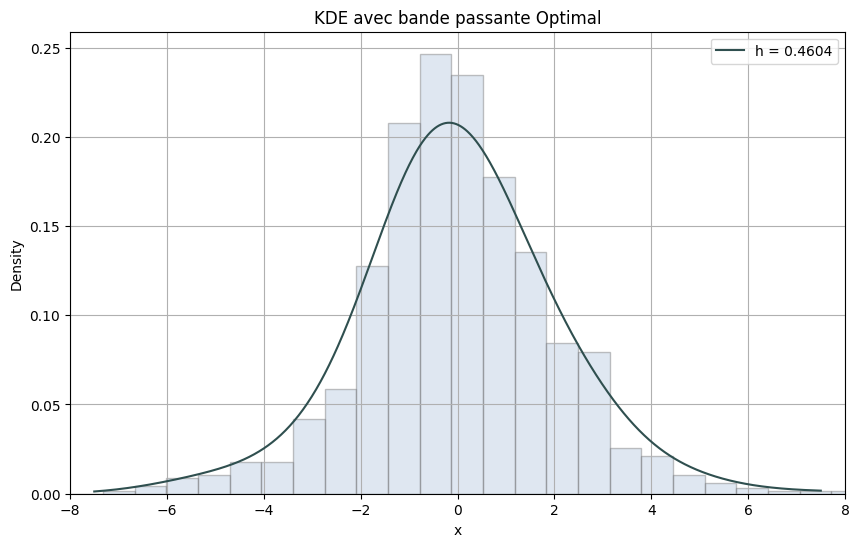

In [16]:
label = "h = " + str(round(optimal_h, 4))
x_values = np.linspace(-7.5, 7.5, 1000)
KDE_optimal = kde.evaluate(x_values)

# Tracer l'histogramme des rendements avec le style spécifié
plt.figure(figsize=(10, 6))
plt.hist(returns[returns != 0], bins=40, density=True, edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_optimal, color='darkslategray', label=label)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-8, 8)
plt.grid(True)
plt.title("KDE avec bande passante Optimal")
plt.show()
